In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# Generating World Points for Camera Calibration

1. Define the Boundaries of the World Coordinate System

Define a 3D space bounded by a box centered at the origin. The dimensions of the bounding box are given by length, width, and height:

$$
\text{Length} = L, \quad \text{Width} = W, \quad \text{Height} = H
$$

We divide them by 2 because we have to generate equal points in negative and positive axis.

2. Generate Random Points

Generate random points uniformly distributed within the bounding box:

$$
x_{\text{rand}} \sim \text{Uniform}(x_{\text{min}}, x_{\text{max}})
$$
$$
y_{\text{rand}} \sim \text{Uniform}(y_{\text{min}}, y_{\text{max}})
$$
$$
z_{\text{rand}} \sim \text{Uniform}(z_{\text{min}}, z_{\text{max}})
$$

Each random point is represented in homogeneous coordinates as:

$$
\text{points}_{\text{rand}} = \begin{bmatrix}
x_{\text{rand}} \\
y_{\text{rand}} \\
z_{\text{rand}} \\
1
\end{bmatrix}
$$

3. Generate Boundary Points

Generate points at the corners of the bounding box. 

In homogeneous coordinates, these boundary points are:

$$
\text{points}_{\text{bound}} = \begin{bmatrix}
x_{\text{bound}} \\
y_{\text{bound}} \\
z_{\text{bound}} \\
1
\end{bmatrix}
$$

4. Combine Random and Boundary Points

Combine the random and boundary points into a single array:

$$
\text{world\_points} = \text{concatenate}(\text{points}_{\text{rand}}, \text{points}_{\text{bound}})
$$

5. Return Transposed World Points

Return the set of world points in a transposed format, where each row represents a point and each column represents a coordinate dimension:

$$
\text{world\_points}^T = \begin{bmatrix}
x_1 & y_1 & z_1 & 1 \\
x_2 & y_2 & z_2 & 1 \\
\vdots & \vdots & \vdots & \vdots \\
x_n & y_n & z_n & 1
\end{bmatrix}
$$
Transpose is takes be cause $\text{12} \times \text{4}$ into $\text{4} \times \text{12}$.

In [107]:
def generate_world_points(length, width, height, num_points):

    # Define the bounds for random points generation
    x_min = -length/2
    x_max = length/2
    y_min = -width/2
    y_max = width/2
    z_min = -height/2
    z_max = height/2

    # Generate random points
    x_rand = np.random.uniform(x_min, x_max, num_points-8)
    y_rand = np.random.uniform(y_min, y_max, num_points-8)
    z_rand = np.random.uniform(z_min, z_max, num_points-8)

    # Combine the random points into a single array
    points_rand = np.stack(
        (x_rand, y_rand, z_rand, np.ones((num_points-8))), axis=1)

    # Generate boundary points
    x_bound = np.array([x_min, x_max, x_min, x_max,
                       x_min, x_max, x_min, x_max])
    y_bound = np.array([y_min, y_min, y_max, y_max,
                       y_min, y_min, y_max, y_max])
    z_bound = np.array([z_min, z_min, z_min, z_min,
                       z_max, z_max, z_max, z_max])

    # Combine the boundary points into a single array
    points_bound = np.stack((x_bound, y_bound, z_bound, np.ones((8))), axis=1)

    # Combine all the points
    world_points = np.concatenate((points_rand, points_bound), axis=0)

    return world_points.T


In [108]:
def convert_to_radians(theeta_x, theeta_y, theeta_z):
    #Convert the angle to theetha
    theeta_x = theeta_x * np.pi/180
    theeta_y = theeta_y * np.pi/180
    theeta_z = theeta_z * np.pi/180

    return theeta_x, theeta_y, theeta_z


Projection Matrix :  $P_{mat}= M_{int} * M_{ext}$

So we have : 

1. Intrinsic Paramters:

$M_{int}=
\left[\begin{matrix}
fk_x & S & C_x & 0\\
0 & fk_y & C_y & 0\\
0 & 0 & 1 & 0
\end{matrix}\right]$

2. Extrinsic Paramters:
$M_{ext}=
\left[\begin{matrix}
R & T\\
0 & 1
\end{matrix}\right]$


$ T=
\left[\begin{matrix}
x \\
y \\
z \\
1
\end{matrix}\right]$

We multiply these rotations to have the total rotation of the system: 

$R_t = R_z * R_y * R_z $

with $\beta$ is the angle of rotation around _'x'_, $\alpha$ around _'y'_ and $\theta$ around _'z'_ 

$R_{z}=
\left[\begin{matrix}
cos(\theta) & -sin(\theta) & 0\\
sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 1 
\end{matrix}\right]$


$R_{y}=
\left[\begin{matrix}
cos(\alpha) & 0 & sin(\alpha)\\
 0 & 1 & 0\\
-sin(\alpha) & 0 & cos(\alpha) 
\end{matrix}\right]$


$R_{x}=
\left[\begin{matrix}
1 & 0 & 0\\
0 & cos(\beta) & -sin(\beta)\\
0 & sin(\beta) & cos(\beta) 
\end{matrix}\right]$

**Combining the Rotations:**

First, compute \( R_{yx} \) by multiplying \( R_y \) and \( R_x \):

$$
R_{yx} = R_y \cdot R_x =
\begin{bmatrix}
\cos(\alpha) & 0 & \sin(\alpha) \\
0 & 1 & 0 \\
-\sin(\alpha) & 0 & \cos(\alpha)
\end{bmatrix}
\cdot
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\beta) & -\sin(\beta) \\
0 & \sin(\beta) & \cos(\beta)
\end{bmatrix}
=
\begin{bmatrix}
\cos(\alpha) & \sin(\alpha) \sin(\beta) & \sin(\alpha) \cos(\beta) \\
0 & \cos(\beta) & -\sin(\beta) \\
-\sin(\alpha) & \cos(\alpha) \sin(\beta) & \cos(\alpha) \cos(\beta)
\end{bmatrix}
$$

Then, compute the total rotation matrix \( R_t \) by multiplying \( R_z \) and \( R_{yx} \):

$$
R_t = R_z \cdot R_{yx} =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
\cos(\alpha) & \sin(\alpha) \sin(\beta) & \sin(\alpha) \cos(\beta) \\
0 & \cos(\beta) & -\sin(\beta) \\
-\sin(\alpha) & \cos(\alpha) \sin(\beta) & \cos(\alpha) \cos(\beta)
\end{bmatrix}
$$

Performing this matrix multiplication yields:

$$
R_t =
\begin{bmatrix}
\cos(\theta) \cos(\alpha) - \sin(\theta) \sin(\alpha) \sin(\beta) & \cos(\theta) \sin(\alpha) \cos(\beta) - \sin(\theta) \cos(\alpha) \sin(\beta) & \cos(\theta) \sin(\alpha) \cos(\beta) - \sin(\theta) \sin(\alpha) \cos(\beta) \\
\sin(\theta) \cos(\alpha) + \cos(\theta) \sin(\alpha) \sin(\beta) & \sin(\theta) \sin(\alpha) \cos(\beta) + \cos(\theta) \cos(\alpha) \sin(\beta) & \sin(\theta) \cos(\alpha) \cos(\beta) + \cos(\theta) \sin(\alpha) \cos(\beta) \\
-\cos(\beta) \sin(\alpha) & \cos(\alpha) \cos(\beta) & \sin(\beta)
\end{bmatrix}
$$

This matrix \( R_t \) represents the cumulative rotation after applying the rotations around the \(x\), \(y\), and \(z\) axes in the specified order.

In [109]:
def calculate_rotation_matrix(theeta_x, theeta_y, theeta_z):
    theeta_x, theeta_y, theeta_z = convert_to_radians(theeta_x, theeta_y, theeta_z)

    # Rotation Matrix for 'x' orientation
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theeta_x), -np.sin(theeta_x)],
        [0, np.sin(theeta_x), np.cos(theeta_x)],
        [0, 0, 0]])

    # Rotation Matrix for 'y' orientation
    Ry = np.array([
        [np.cos(theeta_y), 0, np.sin(theeta_y)],
        [0, 1, 0],
        [-np.sin(theeta_y), 0, np.cos(theeta_y)],
        [0, 0, 0]])

    # Rotation Matrix for 'z' orientation
    Rz = np.matrix([
        [np.cos(theeta_z), -np.sin(theeta_z), 0],
        [np.sin(theeta_z), np.cos(theeta_z), 0],
        [0, 0, 1],
        [0, 0, 0]])

    # Calculate the final rotation matrix R by multiplying Rz, Ry.T and Rx
    R = np.dot(Rz, Ry.T)
    R = np.dot(R, Rx)

    return R


In [110]:
def translation_matrix(tx, ty, tz):
    # Make the Rotation Matrix
    t = np.array([[tx],
                  [ty],
                  [tz],
                  [1]])
    
    return t


In [111]:
def intrinsics(fx, fy, cx, cy, s):
    # Define the camera intrinsic matrix
    K = np.array([[fx, 0, 0, 0],
                  [0, fy, 0, 0],
                  [0,  0, 1, 0]])


    I = np.array([[1, s, cx],
                  [0, 1, cy],
                  [0,  0, 1]])
    

    
    return I, K

# Camera Simulation
In this we have to find out Internisic and extrinsic parameters with reference to world cordinated
Now that we have the Extrinsic and Intrinsic Matrixes, we can now simulate a camera.
To simulate a pinhole camera, the mathematical model is:
$P_{image} = M_{intrinsics} * M_{Extrinsics} * P_{world}$

In [112]:
def camera_simulation(X_world, fx, fy, cx, cy, s, R, t):

    # Concatenate the rotation matrix and translation vector to get the extrinsic parameters matrix "Rt"
    Rt = np.hstack((R, t))


    I, K  = intrinsics(fx, fy, cx, cy, s)
   
    print('Intrinsic: \n', I @ K)

    print('Extrinsic: \n',Rt)

    print('The projection Matrix is: \n', I @ K @ Rt)

    # Project the 3D object points onto the image plane
    x_image_hom = I @ K @ Rt @ X_world # perspective projection


    # print("In Homogeneous coordinates, picture point are: \n", x_image_hom.T)

    # normalize by the homogeneous coordinate 
    x_image_hom = np.true_divide(x_image_hom, x_image_hom[-1])
    x_image_hom = np.array(x_image_hom, dtype=float)

    #  print("In Norm Homogeneous coordinates, picture point are: \n", x_image_hom)

    x_image = x_image_hom[:-1]
    x_image = np.array(x_image, dtype=float)
    
    # print("In Eculedian coordinates, picture point are: \n", x_image.T)
    # print("In Eculedian coordinates, World point are: \n", X_world[:-1].T)

    return x_image, X_world


# Camera Calibration using DLT method:

**Objective**: To determine the camera projection matrix \( P \) that maps 3D world coordinates to 2D image coordinates.

#### Procedure:

1. **Matrix Construction**:

   Given \( n \) 3D world points $(X_i, Y_i, Z_i) $ and corresponding 2D image points $ (x_i, y_i) $, construct a matrix $ A $ of size $ 2n \times 12 $ to relate the 3D points to their 2D projections.

2. **Populating Matrix \( A \)**:

   For each point pair $ (X_i, Y_i, Z_i) $ and $ (x_i, y_i) $, populate matrix $A $ as follows:

   $$
   A[2i, :] = [X_i, Y_i, Z_i, 1, 0, 0, 0, 0, -x_i X_i, -x_i Y_i, -x_i Z_i, -x_i]
   $$

   $$
   A[2i+1, :] = [0, 0, 0, 0, X_i, Y_i, Z_i, 1, -y_i X_i, -y_i Y_i, -y_i Z_i, -y_i]
  $$

3. **Singular Value Decomposition (SVD)**:

   Apply Singular Value Decomposition to matrix \( A \):

$$
   A = U \Sigma V^T
   $$

   Where:
   - \( U \) is an orthogonal matrix.
   - $ \Sigma $ is a diagonal matrix of singular values.
   - \( V^T \) is the transpose of an orthogonal matrix.

4. **Form the Projection Matrix \( P \)**:

   Extract the projection matrix \( P \) from the last row of \( V^T \) (or the last column of \( V \)) and reshape it into a \( 3 \times 4 \) matrix:

   $$
   P = \text{reshape}(V^T[-1], 3, 4)
   $$

5. **Normalization**:

   Normalize the matrix \( P \) by dividing by the element \( P[2, 2] \):

   $$
   P = \frac{P}{P[2, 2]}
   $$

6. **Rounding**:

   Round the entries of \( P \) to a specified number of decimal places, typically to 5 decimal places:

   $$
   P = \text{round}(P, \text{decimals}=5)
   $$

In [113]:
def camera_calibration_dlt(world_points, image_points):
    """
    Calibrate camera using DLT method
    :param world_points: 3D world points (nx3)
    :param image_points: 2D image points (nx2)
    :return: calibration matrix (3x4)
    :NOTE: Some help was taken from the Notes of (Prof. Dr. Cyrill Stachniss) for the execution of this.
    """
    # Get number of points
    n = world_points.shape[0]
    A = np.zeros((2*n, 12))
   
    # Iterate through the points
    for i in range(n):
        # Get world point
        X, Y, Z = world_points[i,:]
        # Get image point
        x, y = image_points[i,:]
        # Construct the first & second row of matrix A
        A[2*i, :] = [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x]
        A[2*i+1, :] = [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
       

    # Perform singular value decomposition on A
    U, S, VT = np.linalg.svd(A)
    # Get the last row of VT which has the eign vector associated with the smallest eign value
    P = VT[-1].reshape(3, 4)

    P = P / P[2,2]

    # Round off all entries of M to 2 decimal place
    P = np.around(P, decimals=5)
  
    # Return the matrix M
    return P

# Ploting the World points in 3-D and Image points in 2-D

In [114]:
def visualize(x_image, X_world):

    X_world = X_world[:-1]
    X_world = np.array(X_world, dtype=float)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_world[0], X_world[1], X_world[2], color = 'red', marker='X')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("World Points in 3D")
    plt.show()

    fig = plt.figure()
    plt.scatter(x_image[0], x_image[1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Image Points in 2D")
    plt.grid()
    plt.show()


# Decomposition of Projection Matrix \( P \)
Given a projection matrix \( P \) of size \( 3 \times 4 \), you can decompose it as follows:

$$
P =KR [I \mid -X_o]
$$

where:
- \( K \) and \(R\) is a  $\text{3} \times \text{3}$ matrix.
- \( -X_o \) is a $\text{3} \times \text{1}$ translation vector.
$$
P =[KR \mid -KRX_o]
$$
 \( H \) can be expressed as:
$$
H=KR
$$
$$
h=-KRX_o
$$

where \( H \) is $\text{3} \times \text{3}$ matrices.
and \(h\) is $\text{3} \times \text{1}$ Thus:

$$
P = [H \mid h]
$$

### Steps to Decompose \( P \):

1. **Perform QR Decomposition on $H^{-1}$**:

$$
H^{-1}  = Q^TR^{-1}
$$

where:
- \(Q \) is a $\text{3} \times \text{3}$ orthogonal matrix .
- \( R \) is an upper triangular matrix.

2. **Extract the Intrinsic Matrix \( K \) and Rotation Matrix \( R \)**:

$$
K = R^{-1}
$$

$$
R = Q^T
$$

3. **Normalize \( K \) and \( R \)**:

- Ensure that \( K \) has positive diagonal entries. If any of the diagonal entries of \( K \) are negative, adjust the signs of the appropriate columns of \( K \) and \( R \).

$$
K_{\text{normalized}} = \frac{K}{K_{22}}
$$


4. **Compute the Translation Vector \( X_o \)**:

$$
X_o = -H^{-1}h 
$$





In [115]:
def decompose_projection_matrix(P):
    # Ensure P is a numpy array
    P = np.array(P)
    
    # Extract H and h from P
    H = P[:, :3]  # 3x3 matrix
    h = P[:, 3]   # 3x1 vector

    # Step 1: Compute the inverse of H
    H_inv = np.linalg.inv(H)
    
    # Step 2: Perform QR decomposition on H_inv
    Q, R = np.linalg.qr(H_inv)
    
    # Extract K and R
    R_T = R.T  # Transpose of R is needed to match the format
    K = np.linalg.inv(R_T)  # K is the inverse of R_T
    R = Q.T  # Rotation matrix R is the transpose of Q

    # Normalize intrinsic matrix K
    K = K / K[2, 2]  # Normalize K so that K[2,2] = 1

    # Step 3: Ensure K has positive diagonal entries
    diag_K = np.diag(K)
    if np.any(diag_K <= 0):
        # Adjust signs to make diagonal entries positive
        for i in range(len(diag_K)):
            if diag_K[i] < 0:
                K[:, i] *= -1
                R[i, :] *= -1
    
    # Adjust K and R for the correct coordinate system if needed
    # Uncomment and modify as needed
    # R_pi = np.array([[-1, 0, 0],
    #                  [0, -1, 0],
    #                  [0, 0, 1]])
    # K = np.dot(K, R_pi)
    # R = np.dot(R, R_pi)
    
    # Step 4: Compute the translation vector t
    t = -np.dot(H_inv, h)
    
    # Combine rotation and translation
    Rt = np.hstack((R, t.reshape(-1, 1)))

    return K.T,Rt

In [116]:
# Define the size of the cube for the world co-ordinates
length = 2
width = 2
height = 2
num_points = 12 # Number of World points 

# Defining the extrinsics and intrinsics Parameters.

We can change the values of each parameter as we want from this part of the code.

In [117]:
# Define the camera extrinsic parameters
theeta_x = 0  # Orientation of camera in 'x' direction with refrence from the global frame
theeta_y = 0  # Orientation of camera in 'y' direction with refrence from the global frame
theeta_z = 0  # Orientation of camera in 'z' direction with refrence from the global frame
tx = 0  # Translation of Camera in 'x' direction with refrence from the global frame
ty = 0  # Translation of Camera in 'y' direction with refrence from the global frame
tz = 0  # Translation of Camera in 'z' direction with refrence from the global frame


In [118]:
# Define the camera intrinsic parameters
fx = 525.0  # focal length in x-direction
fy = 525.0  # focal length in y-direction
cx = 319.5 # principal point in x-direction
cy = 239.5# principal point in y-direction
s =  0.0   # Skew for pixels

In [119]:
R = calculate_rotation_matrix(theeta_x, theeta_y, theeta_z)
t = translation_matrix(tx, ty, tz)
X_world = generate_world_points(length, width, height, num_points)

# X_world = np.array([[1, 1, 1, 1], [1, 1, -1, 1], [1, -1, 1, 1], 
# [1, -1, -1, 1], [-1, 1, 1, 1], [-1, 1, -1, 1], [-1, -1, 1, 1], [-1, -1, -1, 1], [1,-1,0.5, 1],[-1,0.5,1, 1],[0.5,1,1,1]]).T

# Main body of the code

Intrinsic: 
 [[525.    0.  319.5   0. ]
 [  0.  525.  239.5   0. ]
 [  0.    0.    1.    0. ]]
Extrinsic: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The projection Matrix is: 
 [[525.    0.  319.5   0. ]
 [  0.  525.  239.5   0. ]
 [  0.    0.    1.    0. ]]
The estimated Calibration Matrix is: 
 [[525.   -0.  319.5   0. ]
 [ -0.  525.  239.5  -0. ]
 [ -0.    0.    1.   -0. ]]
_________________Decomposition of P__________________
Intrinsic Matrix K:
 [[525.    0.  319.5]
 [ -0.  525.  239.5]
 [ -0.    0.    1. ]]
Extrinsic Matrix R:
 [[ 1.  0.  0. -0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1. -0.]]


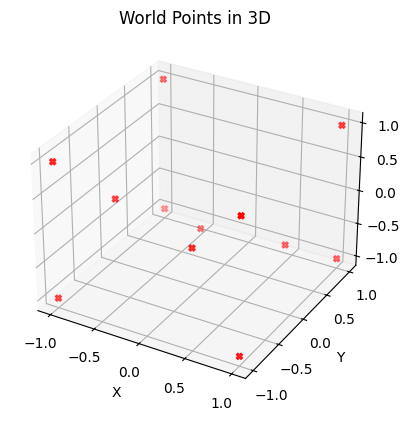

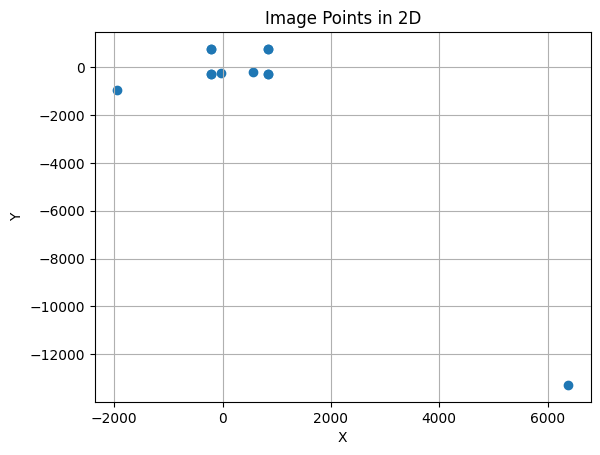

In [120]:
# Perform the camera simulation
x, X = camera_simulation(X_world, fx, fy, cx, cy, s, R, t)

P_est = camera_calibration_dlt(X[:-1].T,x.T)
print("The estimated Calibration Matrix is: \n", P_est)


K, Rt = decompose_projection_matrix(P_est)
print("_________________Decomposition of P__________________")
print("Intrinsic Matrix K:\n", K)
print("Extrinsic Matrix R:\n", Rt)


# Perform the visualization
visualize(x, X)


